In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5.0 , 4.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

np.random.seed(1) #yukardaki değerleri tutmaya çalıştık

### Piksel Ekleme (Padding) Fonksiyonunun Tanımlanması
"""
Veri kümesinin X'in tüm görüntülerini sıfırlarla doldurun. Padding , görüntünün yüksekliğine ve genişliğine uygulanır.
     
   Bağımsız değişken:
    * X :    - m resim grubunu temsil eden python numpy şekil dizisi (m, n_H, n_W, n_C)
    * pad:  - integer, dikey ve yatay boyutlarda her görüntünün etrafındaki padding  miktarı
  *Return:
    * X_pad: şeklin paddingli görüntüsü (m, n_H + 2 * pad, n_W + 2 * pad, n_C)

In [2]:
def zero_pad(X, pad):  
    
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad,pad), (0,0)), 'constant',  constant_values = 0)  #(≈ 1 line)
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


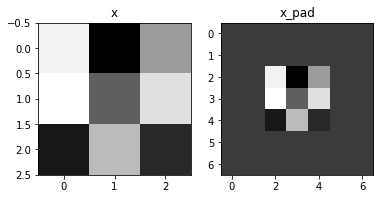

In [3]:
#Piksel ekleme sonucunu görselleştirme
    
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)    #Random 4 x 3 x 3 2 lik bir matris oluşturduk
x_pad = zero_pad(x, 2)             #x,2 lik bir zero padding işlemi yaptık

print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### Bir evrişim işleminin tanımlanması

* çıkış aktivasyonunun tek bir dilimine (a_slice_prev) önceki katmanın W parametreleri 
tarafından tanımlanan  bir filtre uygulayın 

* Argümanlar:

 * a_slice_prev - şeklin giriş verilerinin dilim (f, f, n_C_prev)
 * W - Bir pencerede bulunan ağırlık parametreleri - şekil matrisi (f, f, n_C_prev)
 * b - Bir pencerede bulunan yanlılık parametreleri - şekil matrisi (1, 1, 1)
* Returns:

  * Z - skaler bir değer, sürgülü pencerenin (W, b) giriş verilerinin bir dilimine x döndürülmesinin sonucu

In [4]:
def conv_single_step(a_slince_prev, W , b):
    s = np.multiply(a_slince_prev, W )             # (≈ 2 lines of code)
    Z = np.sum(s)
    Z = float(b)+Z
    return Z


# Z = x.W + b sonunun Hesaplanması
    
np.random.seed(1) 
a_slice_prev = np.random.randn(4, 4, 3)   
W = np.random.randn(4,4,3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


### İleri Yayılım Algoritması için fonksiyon tanımlayalım...


Bir evrişim fonksiyonu için ileriye doğru yayılımı uygular
     
* Argümanlar:
*     A_prev - önceki katmanın çıktı aktivasyonları, sayısal şekil dizisi (m, n_H_prev, n_W_prev, n_C_prev)
 *    W -      Ağırlıklar, sayısal şekil dizisi (f, f, n_C_prev, n_C)
  *   b -      Sapmalar, sayısal şekil dizisi (1, 1, 1, n_C)
   *  hparametreler - "stride" ve "pad" içeren python sözlük
   
* Returns:
     * Z - dönş. Çıktı, sayısal şekil dizisi (m, n_H, n_W, n_C)
     * cache -geri yayılım için hafızaya almamız lazım


In [5]:
def conv_forward(A_prev, W, b, hparameters):
                                                      # Boyutları A_prev'in şeklinden al (≈1 Line)
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape  # n önceki matris, H- Yükseklik, W - Genişlik, C- Kanal Sayısı
   
                                                      ## Boyutları W şeklinden al (≈1 Line)
    (f, f, n_C_prev, n_C) = W.shape                   # kanal sayısı aynı olmak zorunda
    
  
    stride = hparameters['stride']                    # "Hparametrelerden" bilgi al (≈2 Line)
    pad = hparameters['pad']
  
    n_H = int(((n_H_prev-f+2*pad)/stride)+1)          # Evrişimin Çıkış Boyutu Tanımlanıyor
    n_W = int(((n_W_prev-f+2*pad)/stride)+1)          #(≈2 Line)
    
    Z = np.zeros([m,n_H,n_W,n_C])      # (≈1 Line)    #Z çıkış seviyesini sıfırlarla başlatın
    
 
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                      # Eğitim örneği üzerinde döngü                       
        a_prev_pad = A_prev_pad[i]          # Eğitim örnekleri ile paddingli aktivasyon seçin
        
        for h in range(n_H):               # Çıkış  dikey ekseni üzerinde döngü              
            for w in range(n_W):           # Çıkış  yatay ekseni üzerinde döngü        
                for c in range(n_C):       # Çıkış  filtreler ekseni üzerinde döngü     
                    
                    # Mevcut "dilimin" köşelerini bulun (≈4 lines)
                    
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    
                    # A_prev_pad'in (3D) dilimini tanımlamak   (≈1 line)

                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]
                    
                   
                    # Bir çıkış nöronunu geri almak için (3D) 
                    # dilimi doğru filtre W ve b biasıyla birleştirin.  (≈1 line)
                    # Evrişim işlemi Gerçekleşiyor
                    
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                            
   
    assert(Z.shape == (m, n_H, n_W, n_C)) # çıkış değerinin doğruluğunu kontrol edelim
    
   
    cache = (A_prev, W, b, hparameters) #geriye yayılım için bu değerlerin saklanması gerek
                                        #sakla
                                        
    
    return Z, cache

np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)

hparameters = {"pad" :2,
              "stride" :2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

print("Z'nin ortalama =", np.mean(Z))
print("Z[3, 2, 1] =", Z[3, 2, 1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z'nin ortalama = 0.048995203528855794
Z[3, 2, 1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


### Ortaklama katmanı

Ortaklama katmanının ileri geçişini uygular
 * Argümanlar:
 *    A_prev        - Giriş verileri, sayısal şekil dizisi (m, n_H_prev, n_W_prev, n_C_prev)
  *   hparametreler - "f" ve "stride" içeren python sözlük
   *  mode          -kullanmak istediğiniz Ortaklama modu 
        (dize ("maks" veya "ortalama") olarak tanımlanır)
 * Returns:
    
     * A -     Ortaklama katmanının çıktısı, sayısal bir şekil dizisi (m, n_H, n_W, n_C)
     * Cache - Ortaklama katmanının geriye doğru geçişinde kullanılan önbellek, 
        girişi ve hparametreleri içerir

In [6]:
def pool_forward(A_prev, hparameters,mode = "max"):
  
  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape   #Giriş Değerlerinin boyutlarını tanımdadık
                                                     #
  
  f = hparameters["f"]                               # hparametersleri tanımladık
  stride = hparameters["stride"]
   
  n_H = int(1 + (n_H_prev -f)/ stride)               # Padding uygulanan, Ortaklama yapılcak
  n_W = int(1 + (n_W_prev -f)/ stride)               #  Çıktının boyutlarını tanımlayın
  n_C = n_C_prev                                                   
  
  
  A = np.zeros((m, n_H, n_W, n_C))    # A matrisini tanımlayın
  
  for i in range(m):                  # eğitim örnekleri üzerinde döngü
    for h in range(n_H):              # Çıkış  dikey ekseni üzerinde döngü           
      for w in range(n_W):            # Çıkış  yatay ekseni üzerinde döngü 
        for c in range(n_C):          # Çıkış  filtreler ekseni üzerinde döngü  
          
            # Mevcut "dilimin" köşelerini bulun (≈4 lines)
          vert_start = h*stride
          vert_end = vert_start +f
          horiz_start = w*stride
          horiz_end = horiz_start +f
          
          # KAnal sayısı ve C (filtreler )kullanalırak hesaplanacak
          a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
          
          # Dilim üzerindeki ortaklama işlemini hesaplayın. 
          if mode == "max":
            A[i,h, w, c] = np.max(a_prev_slice)
          elif mode == "average":
            A[i,h, w, c] = np.mean(a_prev_slice)
    
  # Girdi ve hparametreleri pool_backward için "cache" de saklayın ()        
  cache = (A_prev, hparameters)
  
  assert(A.shape == (m, n_H, n_W, n_C))   #doğrulama
  
  return A, cache
    


np.random.seed(1)

A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f" :3}

A, cache = pool_forward(A_prev, hparameters)

print("mod = max")
print("A= ", A)

A, cache = pool_forward(A_prev, hparameters, mode = "average")

print("mod = average")
print("A =", A)

mod = max
A=  [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]
mod = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


### Geriye Yayılım Algoritması için Fonksiyon Tanımlayalım!

Bir evrişim fonksiyonu için geriye doğru yayılım uygulamak. Türev alarak
     
 * Argümanlar:
 *    dZ - döngü katmanının (Z), sayısal şekil dizisinin (m, n_H, n_W, n_C) çıktısına göre maliyetin gradyanı
  *   cache - conv_backward () için gereken değerlerin önbelleği, conv_forward () çıktısı
  
* Returns:

    * dA_prev - döngü katmanının (A_prev) girdisine göre maliyetin gradyanı,numpy şekil dizisi 
            (m, n_H_prev, n_W_prev, n_C_prev)
    * dW - döngü tabakasının, (W) ağırlıklarına göre maliyetin gradyanı
           sayısal şekil dizisi (f, f, n_C_prev, n_C)
    * db - dönüşümlü katmanın (b) sapmalarına göre maliyetin gradyanı
           sayısal şekil dizisi (1, 1, 1, n_C)
     

In [7]:
def conv_backward(dZ, cache):
    
    
    
    (A_prev, W, b, hparameters) = cache                 #Cache'den bilgi alma
    
   
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape    # A_prev'den bilşgi alma
    
 
    (f, f, n_C_prev, n_C) = W.shape                     # W'leri almak
    
   
    stride = hparameters['stride']                      # "Hparametreler" den bilgi alma
    pad = hparameters['pad']
    

    (m, n_H, n_W, n_C) = dZ.shape                       # Boyutları dZ'nin şeklinden alma
    
    
    # DA_prev, dW, db'yi oluştur
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f,f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

   
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    
    # eğitim örnekleri üzerinde döngü
    for i in range(m):                       
        
        # A_prev_pad and dA_prev_pad eğitim için seçin
        
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                 # Çıkış  dikey ekseni üzerinde döngü             
            for w in range(n_W):             # Çıkış  yatay ekseni üzerinde döngü   
                for c in range(n_C):         # Çıkış  filtre ekseni üzerinde döngü
                    
                   
                    # Mevcut "dilimin" köşelerini bulun (lines = 4)
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                   
                    # A_prev_pad'in (3D) dilimini tanımlamak için köşeleri kullanın (Hücrenin yukarısındaki İpucu). (≈1 Lines)
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    
                    # Yukarıda verilen kod formüllerini kullanarak pencerelerin, filtrenin parametreleri için  güncelleme
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
         
         # Eğitim örneğinin dA_prev'ini unpaded da_prev_pad olarak ayarlayın (İpucu: X kullanın [pad: -pad, pad: -pad,:])           
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
   
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)

print("dA ortalama =", np.mean(dA))
print("dW ortalama =", np.mean(dW))
print("db ortalama =", np.mean(db))

dA ortalama = 0.6347704472654743
dW ortalama = 1.5572657428497354
db ortalama = 7.839232564616838


### Maske = Filtre --- >Maks
"""

X'in maksimum girişini tanımlamak için x giriş matrisinden bir maske oluşturur.

    Argümanlar:
    x - Şekil dizisi (f, f)
    Returns:
    mask - Pencereyle aynı şekle sahip bir dizi, x'in maksimum girişine karşılık gelen konumda bir True döndürür.

In [8]:
def create_mask_from_window(x):
  
  mask = x == np.max(x)
  
  return mask

#geri yayılımda hata max değerden geleceği için sadece onu True yaptık...
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)

print('x =', x)
print('maske =', mask)

x = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
maske = [[ True False False]
 [False False False]]


### Ortalama ortaklama

Girdi değerini boyut şekli matrisine dağıtır

    Argümanlar:
    dz - giriş skaleri
    şekil - dz değerini dağıtmak istediğimiz çıktı matrisinin şekli (n_H, n_W)
    Return:
    a - dz değerini dağıttığımız boyut dizisi (n_H, n_W)

In [9]:
def distribute_value(dz, shape):
  
   
#   Boyutları şekilden al (≈1 Lines)
    (n_H, n_W) = shape
    
   # Matriste dağıtılacak değeri hesaplayın (≈1 Lines)
    average = dz / (n_H * n_W)
    
   
     # Her girişin "ortalama" değer olduğu bir matris oluşturun (≈1 lines)
    a =  np.ones(shape) * average
    
    return a


a = distribute_value(2, (2,2))

print('Dağıtılmış değer =', a)

Dağıtılmış değer = [[0.5 0.5]
 [0.5 0.5]]


### Ortaklama geri yayılım

Ortaklama katmanının geriye doğru geçişini uygular

    Argümanlar:
    dA - havuzlama tabakasının çıktısına göre maliyet gradyanı, A ile aynı şekil
    cache - havuz katmanının ileri geçişinden gelen önbellek çıktısı, katmanın girişini ve hparametreleri içerir
    mode - kullanmak istediğiniz havuzlama modu (dize ("maks" veya "ortalama") olarak tanımlanır)
    Returns:
    dA_prev - havuzlama katmanının girdisine göre maliyet gradyanı, A_prev ile aynı şekil

In [10]:
def pool_backward(dA, cache, mode= 'max'):
  
     # Cache bilgi al (≈1 lines)
    (A_prev, hparameters) = cache
    
    #hparameters'ten bilgileri al
    stride = hparameters['stride']
    f = hparameters['f']
    
    # A_prev'in şekli ve dA'nın şekli ((2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
   
    dA_prev = np.zeros(A_prev.shape)
 
    for i in range(m):     # train verisini döndür                 
        
       
        a_prev = A_prev[i] # A_prev'den eğitim örneği seçin (≈1 lines)
        
        for h in range(n_H):        # Çıkış  dikey ekseni üzerinde döngü                 
            for w in range(n_W):    # Çıkış  yatay ekseni üzerinde döngü              
                for c in range(n_C):# Çıkış  filtre ekseni üzerinde döngü          
                    
                    # Mevcut "dilimin" köşelerini bulun (lines4 )
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                  # Her iki modda da geriye doğru yayılımı hesaplayın
                    if mode == "max":
                        
                        
                      # A_prev (≈1 lines) öğesinden geçerli dilim tanımlamak için köşeleri ve "c" yi kullanın
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
            
                        # Maskeyi a_prev_slice'dan oluşturun (line1 satır)
                        mask = create_mask_from_window(a_prev_slice)
                   
                    # DA_prev değerini dA_prev + olarak ayarlayın (maske doğru dA girişiyle çarpılır) (line1 )
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        
                       
                        # A değerini dA'dan alın (≈1 satır
                        da = dA[i,h,w,c]
                      
                        # Filtrenin şeklini f x f olarak tanımlayın (≈1 satır)
                        shape = (f,f)
                        # Doğru dA_prev dilimini elde etmek için dağıtın. yani da'nın dağıtılmış değerini ekleyin. (≈1 satır)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                            
 
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [11]:
#Geriye yayılım ile güncellenen ağırlıklar ve diğer parametreler
    

np.random.seed(1)

A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride": 1, "f":2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode= "max")

print("mod = max")
print('dA ortalaması =', np.max(dA))
print('dA_prev[1,1]', dA_prev[1,1])
print()

dA_prev = pool_backward(dA, cache, mode= "average")

print("mod = average")
print('dA ortalaması =', np.mean(dA))
print('dA_prev[1,1]', dA_prev[1,1])

mod = max
dA ortalaması = 2.528325706806398
dA_prev[1,1] [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mod = average
dA ortalaması = 0.14571390272918056
dA_prev[1,1] [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
